# Content Mining Models

## Table of Contents
##### [1. Data Preprocessing and Imports](#preprocessing)
##### [2. Models](#models)
###### [2.1. Cosine Similarity](#cosine)
###### [2.2. LSI Model](#lsi)
###### [2.3. Mixture Model](#mixture)
##### [3. Interpretation and Evaluation](#interpretation_evaluation)

<a id='preprocessing'></a>
## 1. Data Preprocessing and Imports

In [70]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt

In [71]:
# Import functions module
%run functions.py

In [72]:
interactions_data = pd.read_csv(
        'C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Semester 2/Web Mining/Project/RAW_interactions.csv')
recipes_data = pd.read_csv(
        'C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Semester 2/Web Mining/Project/RAW_recipes.csv')


In [73]:
#make copies so that we don't have to reload the data
df_r = recipes_data.copy()
df_i = interactions_data.copy()

In [74]:
# Rename columns to more explanatory names
df_r.rename(columns={"id": "recipe_id"}, inplace=True)

In [75]:
#drop the one na row where the title of the recipe is missing
df_r.drop(df_r[df_r["name"].isna()].index, inplace=True)
df_r.shape

(231636, 12)

In [76]:
# add dummy variable to indicate missing descriptions
df_r["description_na"] = df_r["description"].isna().apply(lambda x: 1 if x == True else 0)

df_r["description"] = df_r["description"].fillna("NA")

print("# rows where description is missing:", len(df_r[df_r["description_na"] == 1]), "|| No mistakes?", len(df_r[df_r["description_na"] == 1]) == len(df_r[df_r["description"] == "NA"]))

# rows where description is missing: 4979 || No mistakes? True


In [77]:
# Change minutes to hours
df_r["hours"] = df_r["minutes"]/60
df_i.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [78]:
#Correct some obvious outliers, but rest of the large recipes are liquors that take months to make

df_r.loc[144074, "minutes"]= 25
df_r.drop(df_r[df_r["name"]=="how to preserve a husband"].index, inplace=True)
df_r.shape

(231635, 14)

In [79]:
# Preprocess ingredients and save as String
for index, row in df_r.iterrows():
    ingredientlist = row['ingredients']
    ingredientlist = row['ingredients'].replace('[', '').replace(', ', '').replace(']', '').replace('and', '\'').split("\'")
    ingredientlist = list(filter(None, ingredientlist))
    ingredientlistString = ""
    for i in ingredientlist:
        ingredientlistString = ingredientlistString + i
    df_r.at[index, 'ingredients'] = ingredientlistString

In [69]:
# # Extract keywords for free text features
# get_keywords(recipes_data, "steps", "steps_keywords")
# get_keywords(recipes_data, "description", "description_keywords")
# get_keywords(interactions_data, "review", "review_keywords")

In [80]:
# Merge datasets
#create num_interactions & average ratings column

num_interactions = df_i.groupby("recipe_id")["date"].count()
#only consider the ratings (>0) into the mean, not the reviews w/o ratings
mean_ratings = df_i[df_i["rating"]!=0].groupby("recipe_id")["rating"].mean()

df_rmerged = df_r.join(num_interactions, how="left", on="recipe_id").join(mean_ratings, how="left", on="recipe_id")


print("shape after merging:", df_rmerged.shape)

df_rmerged = df_rmerged.rename(columns ={"date":"num_interactions", "rating":"avg_rating"})
df_rmerged.head()

shape after merging: (231635, 16)


,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,winter squashmexican seasoningmixed spicehoney...,7,0,0.916667,3,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,prepared pizza crustsausage pattyeggsmilksalt ...,6,0,0.500000,4,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,ground beefyellow onionsdiced tomatoestomato p...,13,0,2.166667,1,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",spreadable cheese with garlic herbsnew potato...,11,0,0.750000,2,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,tomato juiceapple cider vinegarsugarsaltpepper...,8,0,3.166667,1,5.000000


C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  1450.,   2203.,   8200.,  39563., 175173.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

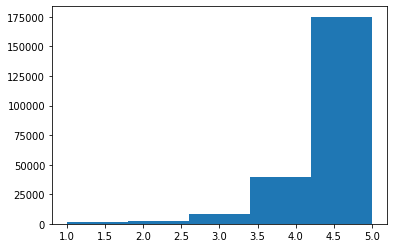

In [81]:
plt.hist(df_rmerged['avg_rating'], bins = 5)

In [82]:
#We want some quality in our recommended systems, no description of steps is bad
df_rmerged.drop(df_rmerged[df_rmerged['n_steps']==0].index, inplace=True)

In [83]:
#Preprocess the "submitted" column
df_rmerged["submitted"] = df_rmerged["submitted"].astype(str)

dates = pd.DataFrame(df_rmerged["submitted"].apply(lambda date: date.split("-")).tolist(), index = df_rmerged.index,columns =["year", "month", "day"])

df_rmerged["year"] = dates ["year"]
df_rmerged["month"] = dates["month"]

#create an age column for the recipes
df_rmerged["year"]= df_rmerged["year"].astype(int)
df_rmerged["month"]=df_rmerged["month"].astype(int)
df_rmerged["age"] = (2019-df_rmerged.year)+ df_rmerged.month/12

In [84]:
#remove all recipes which are older/younger than 8 years and have less than 15/10 interactions

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=15) & (df_rmerged["age"]>8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing old & inactive recipes:", df_rmerged.shape)

index_remove= df_rmerged[(df_rmerged["num_interactions"]<=10)& (df_rmerged["age"]<=8.0)]["recipe_id"].index

df_rmerged.drop(index_remove, axis=0, inplace=True)

print("Shape after removing newer & inactive recipes:", df_rmerged.shape)

Shape after removing old & inactive recipes: (21913, 19)
Shape after removing newer & inactive recipes: (11151, 19)


In [85]:
#1 step recipes are not inherently bad, often they are just all steps written into one field, but let's filter by interactions

df_rmerged.drop(df_rmerged[(df_rmerged["n_steps"]==1)&(df_rmerged["num_interactions"]==1)].index, axis=0, inplace =True)
print("Shape after removing 1 step recipes w/ low interactions:", df_rmerged.shape)

Shape after removing 1 step recipes w/ low interactions: (11151, 19)


In [86]:
# same for recipes which don't have any time instructions

df_rmerged.drop(df_rmerged[(df_rmerged['minutes']==0)].index, axis=0, inplace=True)
print('Shape after removing 0 minutes interaction w/ low interactions:', df_rmerged.shape)

Shape after removing 0 minutes interaction w/ low interactions: (11103, 19)


#### Drop duplicate recipes

In [87]:
#do we have duplicate recipe titles?
print("# duplicate recipe titles:",len(df_rmerged["name"])-len(df_rmerged["name"].unique()))

# duplicate recipe titles: 13


In [88]:
def choose_best(interactions, ratings, n_dupl):
    # number of interaction are different -> there exists a maximum
    if((len(interactions) != len(set(interactions)))) :
        return interactions.idxmax(axis=1)
    else:# return the maximum rating or any of the duplicate recipes
        return ratings.idxmax(axis=1)

In [89]:
dupl_recipes = pd.DataFrame(df_rmerged[df_rmerged["name"].duplicated(keep=False)])
dupl_rgrouped= dupl_recipes.groupby('name').groups

to_keep = []

for name in dupl_rgrouped:
    n_dupl = len(dupl_rgrouped[name])
    if(n_dupl == 2):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        
        interactions = dupl_recipes.loc[[index1, index2], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2], ['avg_rating']].avg_rating
        
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    elif (n_dupl==3):
        index1=dupl_rgrouped[name][0]
        index2=dupl_rgrouped[name][1]
        index3=dupl_rgrouped[name][2]
        
        interactions = dupl_recipes.loc[[index1, index2, index3], ['num_interactions']].num_interactions
        ratings = dupl_recipes.loc[[index1, index2, index3], ['avg_rating']].avg_rating
        to_keep.append(choose_best(interactions, ratings, n_dupl))
    else:
        print("Error")
        break 

df_rmerged.drop(df_rmerged.index.intersection(to_keep), axis=0, inplace=True)
print('Shape after dropping duplicates:', df_rmerged.shape)

Shape after dropping duplicates: (11090, 19)


In [90]:
# Check for ratings with 0 or NA value
print("is 0 ratings:", df_rmerged[df_rmerged["avg_rating"]==0].sum())
print("is na ratings:", df_rmerged["avg_rating"].isna().sum())

is 0 ratings: name                0.0
recipe_id           0.0
minutes             0.0
contributor_id      0.0
submitted           0.0
tags                0.0
nutrition           0.0
n_steps             0.0
steps               0.0
description         0.0
ingredients         0.0
n_ingredients       0.0
description_na      0.0
hours               0.0
num_interactions    0.0
avg_rating          0.0
year                0.0
month               0.0
age                 0.0
dtype: float64
is na ratings: 0


### Create user-interaction data

In [91]:
df_uactivity = df_i[['recipe_id','user_id', 'rating']]

In [92]:
#Create a user activity dataframe

df_uactivity = df_uactivity.groupby('user_id')['rating'].value_counts().unstack().fillna(0)

cols = list(df_uactivity)
df_uactivity['total_interactions'] = df_uactivity[cols].sum(axis=1)
df_uactivity['total_ratings'] = df_uactivity['total_interactions']-df_uactivity[0]

df_uactivity.head()

rating,0,1,2,3,4,5,total_interactions,total_ratings
user_id,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0
1581,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0


In [93]:
# Filter out inactive users 
df_uactivity = df_uactivity[df_uactivity['total_interactions']>=7]
df_uactivity.shape

(17099, 8)

In [94]:
# Create average rating per user
df_uactivity['uavg_rating'] = df_uactivity.iloc[:,1:6].apply(
    lambda row: np.round(np.ma.average(list(range(1,6)), weights = (row[1], row[2], row[3], row[4], row[5])),1), axis = 1)
display(df_uactivity.head())
df_uactivity.shape

C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\ma\extras.py:608: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


rating,0,1,2,3,4,5,total_interactions,total_ratings,uavg_rating
user_id,,,,,,,,,
1533,0.0,2.0,5.0,1.0,12.0,108.0,128.0,128.0,4.7
1535,6.0,1.0,10.0,53.0,248.0,476.0,794.0,788.0,4.5
1634,9.0,0.0,2.0,7.0,18.0,24.0,60.0,51.0,4.3
1676,0.0,1.0,0.0,2.0,2.0,26.0,31.0,31.0,4.7
1792,0.0,0.0,0.0,5.0,5.0,21.0,31.0,31.0,4.5


(17099, 9)

In [95]:
df_uactivity = df_uactivity.reset_index()
df_uactivity.columns.set_names(None, inplace = True)

In [96]:
#drop users that only have reviews but no ratings

df_uactivity.drop(df_uactivity[df_uactivity.total_ratings == 0].index, inplace=True, axis=0)
df_uactivity.shape

(17088, 10)

### Create filtered interactions data frame

In [97]:
# 1. Create Filter for interations with filtered df_uactivity -> Only interactions from active users remain

user_filter = pd.merge(df_uactivity[['user_id']], df_i[['recipe_id','user_id', 'rating']], how = 'left', on ='user_id')

display(user_filter.head())
user_filter.shape

,user_id,recipe_id,rating
0,1533,116345,5
1,1533,32907,5
2,1533,14750,5
3,1533,24136,5
4,1533,63598,4


(839343, 3)

In [98]:
# 2. Filter interactions with active recipes -> Only interactions from active users and clean recipes remain

interactions = pd.merge(df_rmerged[['recipe_id']], user_filter[['recipe_id', 'user_id', 'rating']], on = 'recipe_id', how ='inner')
display(interactions.head())
interactions.shape

,recipe_id,user_id,rating
0,63986,4470,5
1,63986,28649,4
2,63986,37471,5
3,63986,60992,5
4,63986,75497,5


(328731, 3)

#### Set 0 ratings to average rating

In [99]:
def impute_average_rating(row):
    if (row['rating'] == 0):
        imputed_rating = round(df_uactivity.loc[df_uactivity.user_id == row.user_id, 'uavg_rating'].values[0], 0)
        return imputed_rating
    else:
        return row.rating

In [100]:
interactions['rating'] = interactions.apply(impute_average_rating, axis=1)

In [101]:
def get_rating_dist(df_column):
    ratings_series=pd.Series(df_column.value_counts())
    ratings_series.plot.bar()
    print(f'Percent of 5 star rating interactions: {round((ratings_series.loc[5]/len(df_column)*100),2)}%')
    print(f'Percent of 4 star rating interactions: {round((ratings_series.loc[4]/len(df_column)*100),2)}%')
    print(f'Percent of 3 star rating interactions: {round((ratings_series.loc[3]/len(df_column)*100),2)}%')
    print(f'Percent of 2 star rating interactions: {round((ratings_series.loc[2]/len(df_column)*100),2)}%')
    print(f'Percent of 1 star rating interactions: {round((ratings_series.loc[1]/len(df_column)*100),2)}%')

Percent of 5 star rating interactions: 79.63%
Percent of 4 star rating interactions: 15.58%
Percent of 3 star rating interactions: 3.29%
Percent of 2 star rating interactions: 1.03%
Percent of 1 star rating interactions: 0.47%


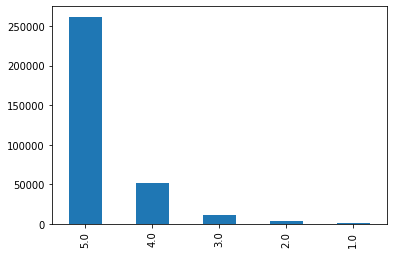

In [102]:
#Let's look at the distribution of ratings
get_rating_dist(interactions.rating)

### NLP Preprocessing

In [103]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [104]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    #stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [105]:
def get_processed(data):
    processed = pd.DataFrame(data=[],columns = ['recipe_id', 'content'])
    new_texts = []

    for i in range(0, len(data)):
        recipe_id = data['recipe_id'].iloc[i]
        words = nltk.word_tokenize(data['content'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[recipe_id, text]], columns=['recipe_id', 'content'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [143]:
filtered_recipes = pd.unique(interactions['recipe_id'])
df_rfiltered = df_rmerged[df_rmerged.recipe_id.isin(filtered_recipes)]
print(df_rmerged.shape)
df_rfiltered.shape

(11090, 19)


(11050, 19)

In [107]:
def create_content (df, column_names):
    length = len(column_names)
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [144]:
df_rfiltered.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating,year,month,age
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,lean pork chopsfloursaltdry mustardgarlic powd...,7,0,8.333333,19,4.882353,2003,6,16.500000
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",frozen chopped spinacheggsaltblack pepperonion...,8,0,0.833333,113,4.342593,2002,4,17.333333
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,ground beefsugarprepared yellow mustardbeercay...,8,0,0.583333,21,4.200000,2003,4,16.333333
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,rollsbrown sugarinstant vanilla puddingcinnamo...,6,0,0.583333,51,4.734694,2002,3,17.250000
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...",whipping creamvanilla instant pudding mixpowde...,4,0,0.083333,80,4.987179,2003,11,16.916667


In [142]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_rfiltered = create_content(df_rfiltered[['recipe_id', 'name','description', 'steps']], ['name','description', 'steps'])

df_rfiltered.head()

C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,recipe_id,content
15,63986,chicken lickin good pork chops here's and old ...
36,25775,how i got my family to eat spinach spinach cas...
43,58224,immoral sandwich filling loose meat just the t...
53,22526,land of nod cinnamon buns i have made this sev...
67,74805,never weep whipped cream i don't know where i ...


In [109]:
content_processed = get_processed(df_rfiltered)
content_processed.shape

(11050, 2)

In [113]:
sample = content_processed.sample(n=1000, replace=False, random_state=42)\
                 .reset_index()\
                 .drop(columns=['index'])
sample.head()

,recipe_id,content
0,410095,starbucks pumpkin bread favorite pumpkin bread...
1,53081,rockin rice pudding tyler florence know use le...
2,88348,mean chef yucatan style chicken lime orzo soup...
3,27000,creamy apple dessert easy dessert preheat 350f...
4,190896,sesame snow peas good destem peas pinch stem e...


In [114]:
processed = get_processed(sample)
processed.head()

,recipe_id,content
0,410095,starbucks pumpkin bread favorite pumpkin bread...
1,53081,rockin rice pudding tyler florence know use le...
2,88348,mean chef yucatan style chicken lime orzo soup...
3,27000,creamy apple dessert easy dessert preheat 350f...
4,190896,sesame snow peas good destem peas pinch stem e...


<a id='models'></a>
## 2. Models

<a id='cosine'></a>
### 2.1. Cosine Similarity

In [115]:
def get_cos_sim_matrix(processed):
    tfidf = TfidfVectorizer(stop_words='english')
    processed['content'] = processed['content'].fillna('')
    tfidf_matrix = tfidf.fit_transform(processed['content'])
    #reduce dimensionality of tfidf matrix
    svd = TruncatedSVD(n_components=10, random_state=42)
    tfidf_truncated = svd.fit_transform(tfidf_matrix) 
    cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
    return cosine_sim

In [116]:
cosine_sim = get_cos_sim_matrix(content_processed)
cosine_sim.shape

(11050, 11050)

### Make recommendations for Coverage

In [117]:
#return top k predicted ratings in readable form 

# IMPORTANT: must set the dataframe for recipe_info index == recipe_id!
def get_user_recommendations(user_id, similarity, content, interactions, recipe_info, k):
    #get top k recipe ids
    topk_recipes, predictions = get_topk_recipes(user_id, similarity, content, interactions, k)
    info = recipe_info.loc[topk_recipes]
    info['prediction'] = predictions
    return info

def get_topk_recipes(user_id, similarity, content, interactions, k):
    prediction_df = get_user_preference(user_id,similarity, content, interactions)
    #take only the not yet seen recipes
    new_predictions = prediction_df[prediction_df['has_rated'] == False]
    #sort predictions
    ordered_predictions = new_predictions.sort_values(by='prediction', ascending=False)
    #get recipe_id array
    topk_recipes = ordered_predictions.index[:k].values
    predictions = ordered_predictions.prediction[:k].values
    return topk_recipes, predictions

In [118]:
def get_user_preference(user_id, similarity, content, interactions):
    #prepare similarity dataframe
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of ALL recipes w/ already rated recipes of user
    sim_rated_all = sim.loc[rated_recipes, :]
    #get ratings of already rated recipes
    ratings = get_reshaped_ratings(user_id)
    #compute weighted similarities between all recipes and already rated recipes
    weighted_sim = np.dot(ratings,sim_rated_all)
    #compute normalization constant
    norm_const = np.array(np.abs(sim_rated_all).sum(axis=0))
    #return sorted predictions
    pref_predictions = weighted_sim/norm_const
    flat_predictions = [item for sublist in pref_predictions for item in sublist]
    #return df with recipe id also
    prediction_df = pd.DataFrame(flat_predictions, index =content_processed['recipe_id'].values, columns =['prediction'])
    #indicate the already tried recipes
    prediction_df['has_rated'] = prediction_df.index.isin(rated_recipes)
    #order predictions
    return prediction_df

#arrange ratings for matrix multiplication
def get_reshaped_ratings(user_id):
    ratings = interactions[interactions['user_id']==user_id]
    ratings.set_index('recipe_id', inplace=True)
    ratings.index.set_names(None, inplace = True)
    ratings.drop(columns='user_id', inplace=True)
    ratings = ratings.transpose()
    ratings.rename(index={'rating':user_id}, inplace=True)
    return ratings

In [119]:
#Source: https://github.com/statisticianinstilettos/recmetrics/

def catalog_coverage(predicted, catalog, k):
    """
    Computes the catalog coverage for k lists of recommendations
    Parameters
    ----------
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    catalog: list
        A list of all unique items in the training data
        example: ['A', 'B', 'C', 'X', 'Y', Z]
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    Returns
    ----------
    catalog_coverage:
        The catalog coverage of the recommendations as a percent
        rounded to 2 decimal places
    ----------    
    Metric Defintion:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

In [120]:
#TODO
def make_all_recommendations(user_ids):
    return nested_recommendations

In [121]:
get_user_recommendations(60992, cosine_sim, content_processed, interactions, df_rmerged, 5)

C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


KeyError: "None of [Int64Index([29935, 139518, 153343, 458008, 24612], dtype='int64')] are in the [index]"

### Make prediction function --> for RMSE

In [122]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [123]:
#only relevant if there is a recipe sample

def get_interaction_processed(processed, interactions):
    #fetch only interactions in the preprocessed sample
    interactions_processed = interactions.loc[interactions.recipe_id.isin(processed.recipe_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
    print(f'Interactions before processing: {len(interactions.index)}\nInteractions covered in sample: {len(interactions_processed.index)}')
    return interactions_processed

In [124]:
interactions_processed = get_interaction_processed(sample, interactions)
interactions_processed.head()

Interactions before processing: 328731
Interactions covered in sample: 28316


,recipe_id,user_id,rating
0,22526,7798,5.0
1,22526,20480,5.0
2,22526,27798,5.0
3,22526,29063,5.0
4,22526,29212,5.0


#### a) Make predictions based on tfidf

In [125]:
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_cos = []
actual_cos = []

#Make a prediction for each interaction in the interactions df
for i in range(len(interactions)):
    act, pred = get_one_prediction(cosine_sim, content_processed, interactions, uids[i], rids[i])
    predictions_cos.append(pred)
    actual_cos.append(act)

In [133]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

RMSE: 0.5236490480539858, MAE: 0.3245386233762958


In [137]:
interactions['predicted_rating'] = [item for sublist in predictions_cos for item in sublist]
interactions.head()
processed.head()
recipe.head()

NameError: name 'recipe' is not defined

Percent of 5 star rating interactions: 82.54%
Percent of 4 star rating interactions: 16.97%
Percent of 3 star rating interactions: 0.43%
Percent of 2 star rating interactions: 0.05%
Percent of 1 star rating interactions: 0.01%


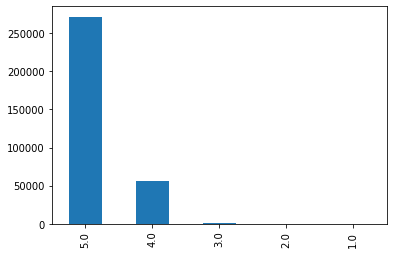

In [135]:
get_rating_dist(round(interactions.predicted_rating))

#### b) Make predictions based on Mixture Model c) based on Word Embeddings etc. ...

In [145]:
interactions.head()
df_rfiltered.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,description_na,hours,num_interactions,avg_rating,year,month,age
15,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,lean pork chopsfloursaltdry mustardgarlic powd...,7,0,8.333333,19,4.882353,2003,6,16.500000
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",frozen chopped spinacheggsaltblack pepperonion...,8,0,0.833333,113,4.342593,2002,4,17.333333
43,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...","[223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,ground beefsugarprepared yellow mustardbeercay...,8,0,0.583333,21,4.200000,2003,4,16.333333
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,rollsbrown sugarinstant vanilla puddingcinnamo...,6,0,0.583333,51,4.734694,2002,3,17.250000
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...",whipping creamvanilla instant pudding mixpowde...,4,0,0.083333,80,4.987179,2003,11,16.916667


In [148]:
def get_mix_sim_matrix(processed, lmbda, df_rfiltered):
  cos_sim = get_cos_sim_matrix(processed)
  df_sub = df_rfiltered[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
  df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')

  scaler = StandardScaler()
  X = scaler.fit_transform(df_processed)
  eucl_dis = euclidean_distances(X,X)

  eucl_sim = 1/np.exp(eucl_dis)
  mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted

  return mixed_sim

In [149]:
mixed_sim = get_mix_sim_matrix(content_processed, 0.5, df_rfiltered)
mixed_sim.shape

(11050, 11050)

In [ ]:
#prediction for 1 already rated recipe based on similarities to other already rated recipes

def get_one_prediction(similarity, content, interactions, user_id, recipe_id):
    sim = pd.DataFrame(similarity, index=content['recipe_id'].values, columns=content['recipe_id'].values)
    #get already rated recipes of user
    rated_recipes = interactions[interactions['user_id']==user_id]['recipe_id'].values
    #get similarities of to be predicted recipe rating with already rated recipes by user x
    sim_rated = sim.loc[sim.index==recipe_id, rated_recipes].loc[recipe_id].values
    #get ratings of rated recipes
    ratings = interactions[interactions['user_id']==user_id]['rating'].values
    
    actual = interactions.loc[(interactions.user_id==user_id) & (interactions.recipe_id==recipe_id)]['rating'].values[0]
    prediction = np.dot(ratings, sim_rated) /np.array([np.abs(sim_rated).sum(axis=0)])
    return actual, prediction

In [153]:
interactions
uids = interactions['user_id'].values
rids = interactions['recipe_id'].values

predictions_mixed = []
actual_mixed = []

#Make a prediction for each interaction in the interactions df
for i in range(len(interactions)):
    act, pred = get_one_prediction(mixed_sim, content_processed, interactions, uids[i], rids[i])
    predictions_mixed.append(pred)
    actual_mixed.append(act)

In [154]:
rmse_mixed = mean_squared_error(predictions_mixed, actual_mixed)**0.5
mae_mixed = mean_absolute_error(predictions_mixed, actual_mixed)
print(f'RMSE: {rmse_mixed}, MAE: {mae_mixed}')

RMSE: 0.5121165032740979, MAE: 0.3157264674553969


In [157]:
interactions['predicted_rating_mixed'] = [item for sublist in predictions_mixed for item in sublist]
interactions.head()

,recipe_id,user_id,rating,predicted_rating,predicted_rating_mixed
0,63986,4470,5.0,4.944262,4.954015
1,63986,28649,4.0,4.722126,4.736936
2,63986,37471,5.0,4.926481,4.941358
3,63986,60992,5.0,4.828718,4.825021
4,63986,75497,5.0,4.223794,4.222638


Percent of 5 star rating interactions: 82.79%
Percent of 4 star rating interactions: 16.72%
Percent of 3 star rating interactions: 0.44%
Percent of 2 star rating interactions: 0.05%
Percent of 1 star rating interactions: 0.01%


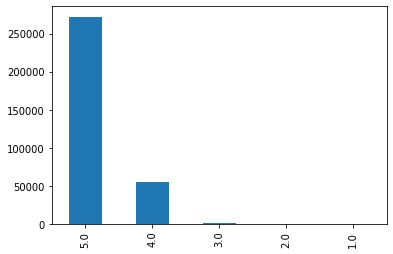

In [158]:
get_rating_dist(round(interactions.predicted_rating_mixed))

<a id='mixture'></a>
### 2.3. Mixture Model

- Improve the model fit by including another similarity measure on top of cosine similarity
- Cosine similarity used to retrive similarity of texutal features
- Euclidean distance used to enhance with similarity of numerical features
- Assumption: Distribution f is a mixture of K komponent distribution each having a mixture weight \lambda_k 
- The new similarity matrix is then a linear combination of the cosine similarity matrix and the euclidean similarity matrix that are multiplied by a factor lambda and 1-lambda
- The optimal value of lambda needs to be optimized afterwards

### 2.3.1. Overall

In [128]:
def get_mix_sim_matrix(processed, lmbda, recipes_data):
  cos_sim = get_cos_sim_matrix(processed)
  df_sub = recipes_data[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
  df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')

  scaler = StandardScaler()
  X = scaler.fit_transform(df_processed)
  eucl_dis = euclidean_distances(X,X)

  eucl_sim = 1/np.exp(eucl_dis)
  mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted

  return mixed_sim

In [129]:
mixed_sim = get_mix_sim_matrix(content_processed, 0.5, df_rfiltered)
mixed_sim.shape

KeyError: "['n_ingredients', 'n_steps', 'minutes'] not in index"

In [159]:
predictions_mix = []
actual_mix = []
for i in range(len(interactions_processed)):
  try:
    act, pred = get_results_cos(processed, 
                                interactions_processed, 
                                recipes_data, 
                                rid_sample[i], 
                                uid_sample[i], 
                                mixed_sim, 
                                5)
    predictions_mix.append(pred)
    actual_mix.append(act)
  except:
    next

In [160]:
rmse_mix = mean_squared_error(predictions_mix, actual_mix)**0.5
mae_mix = mean_absolute_error(predictions_mix, actual_mix)
print(f'RMSE: {rmse_mix}, MAE: {mae_mix}')

RMSE: 1.0518422149832958, MAE: 0.5


In [161]:
cov_mix = get_coverage(processed, interactions_data, recipes_data, mixed_sim, 5)
print(f'coverage: {cov_mix}')

coverage: 0.74


#### 2.3.2. Optimization of Parameter

In [162]:
def tuning_mix_param(lmbdas, processed, interactions_data, recipes_data):
  rmse_mix = []

  interactions_processed = get_interaction_processed(processed, interactions_data)
  uid_sample = interactions_processed['user_id'].values
  rid_sample = interactions_processed['recipe_id'].values

  for lmbda in lmbdas:
    mixed_sim = get_mix_sim_matrix(processed, lmbda, recipes_data)
    predictions_mix, actual_mix = [], []
    for i in range(len(interactions_processed)):
      try:
        act, pred = get_results_cos(processed, 
                                    interactions_processed, 
                                    recipes_data, 
                                    rid_sample[i], 
                                    uid_sample[i], 
                                    mixed_sim, 
                                    5)
        predictions_mix.append(pred)
        actual_mix.append(act)
      except:
        next
    
    rmse = mean_squared_error(predictions_mix, actual_mix)**0.5
    rmse_mix.append(rmse)
  
  return rmse_mix

In [163]:
sample_s = df_content.sample(n=1000, replace=False, random_state=42)\
                  .reset_index()\
                  .drop(columns=['index'])

processed_s = get_processed(sample_s)
lmbdas = np.linspace(0,1,5)

In [164]:
rmse_mix_tune = tuning_mix_param(lmbdas,
                                 processed_s, 
                                 interactions_data, 
                                 recipes_data)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

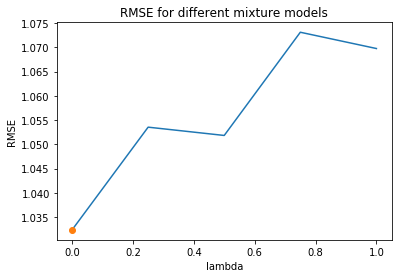

In [165]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

<a id='interpretation_evaluation'></a>
## 3. Interpretation and Evaluation